**INTRODUCTION**

A lot of variables, including location, size, number of rooms, age, and amenities, affect house prices, making precise forecasting difficult. In order to make wise judgments, stakeholders such as buyers, sellers, and investors are depending more and more on data-driven insights due to the quick expansion of real estate markets. Conventional methods, which rely on averages or basic rules, frequently fall short of capturing the complex interactions between features. In order to address this, machine learning (ML) techniques are used to manage non-linear relationships, identify outliers, identify patterns in past housing data, and produce accurate house price predictions. This notebook provides a methodical methodology for reliable home price prediction by implementing an end-to-end machine learning pipeline that covers data exploration, preprocessing, outlier detection, model training, assessment, and visualization.



**BUSINESS PROBLEM**

Accurately predicting house prices is a critical challenge for real estate agents, buyers, sellers, and investors. Inaccurate pricing may result in missed investment possibilities, extended property listings, or monetary losses. The objective is to create a prediction model that can accurately estimate home values based on important characteristics, empowering stakeholders to make well-informed choices, maximize pricing tactics, and boost real estate market profitability.

**PROBLEM STATEMENT**

Goal: Create a machine learning model that can precisely forecast home values using a variety of property attributes.

 Input Data: The dataset contains a variety of attributes, including the property's age, location, area, number of rooms, amenities, and other pertinent housing information.

 Challenge: Accurate forecasting is challenging due to the many interrelated elements that affect house values, as well as the possibility of outliers or skewed distributions.

 Real-World Relevance: By reflecting actual housing market patterns, the data aids in the pricing and investment decisions of buyers, sellers, and investors.

 Objective: Create a strong predictive model that reduces prediction errors and yields accurate estimates to help the real estate industry make better decisions.

**Importing all the necessary libraries**

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    xgb_available = False

import joblib

pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')

In [3]:
from scipy import stats
sns.set_style('whitegrid')
%matplotlib inline

def show_plot():
    plt.tight_layout()
    plt.show()

target_col = "price"

**Load the dataset**

In [4]:
df = pd.read_csv('/content/Housing.csv')

In [5]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
df.tail()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


In [7]:
df.shape

(545, 13)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


**EXPLORATORY DATA ANALYSIS (EDA)**

**Check for missing values**

In [9]:
print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


**Select only numerical columns before calculating correlation**

In [10]:
target_col = "price"
if target_col in df.columns:
    numerical_df = df.select_dtypes(include=np.number)
    corr = numerical_df.corr()[target_col].sort_values(ascending=False)
    print("Top correlations with target:\n", corr.head(10))

Top correlations with target:
 price        1.000000
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


**Plot Histogram of Target Column**

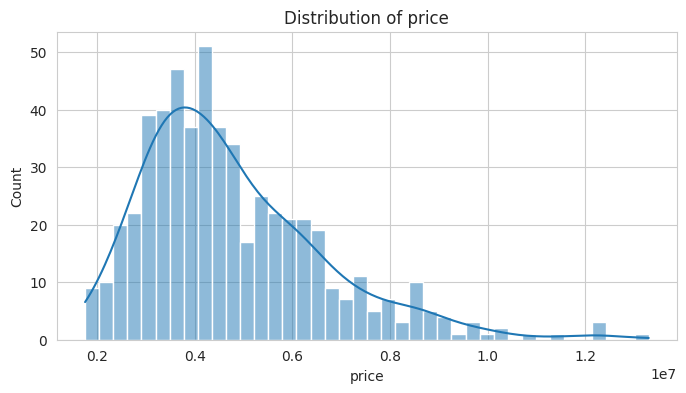

In [11]:
if target_col in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df[target_col], bins=40, kde=True)
    plt.title(f"Distribution of {target_col}")
    plt.show()

**Boxplots for numeric features**

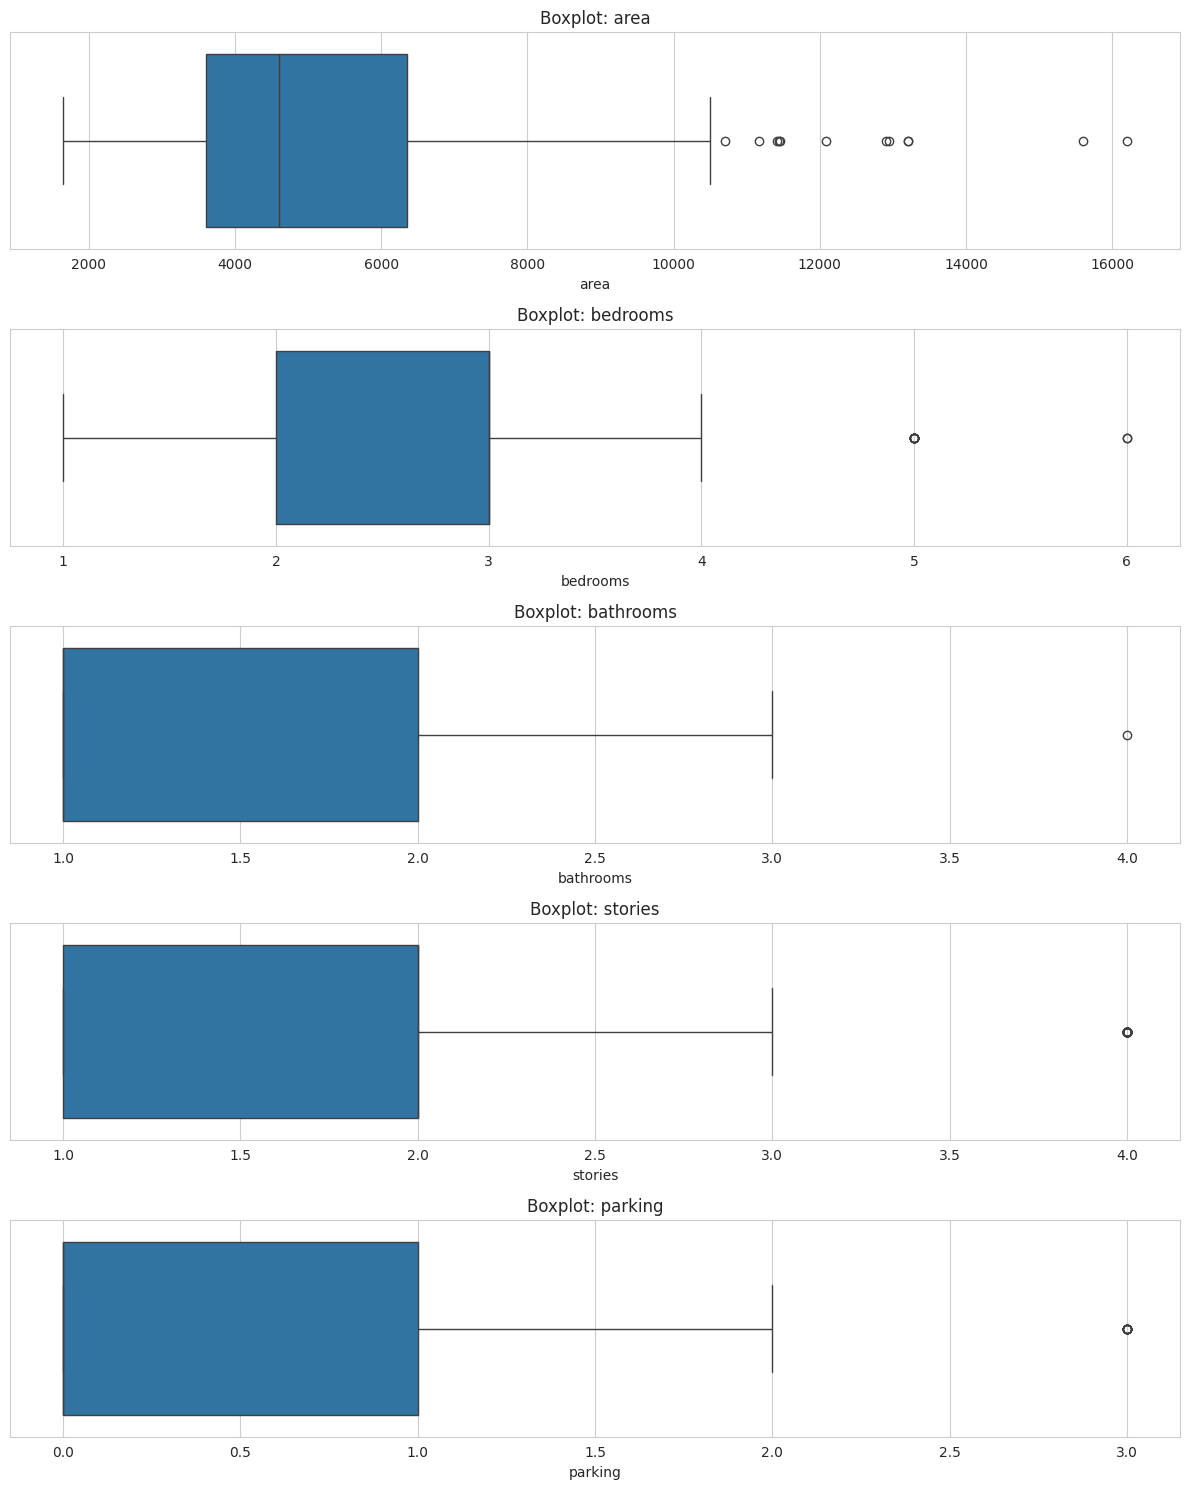

In [12]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop(target_col).tolist()
cols_to_plot = num_cols[:6]  # change indices to view other columns
plt.figure(figsize=(12, 3*len(cols_to_plot)))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(len(cols_to_plot), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
show_plot()

**Scatter plots (feature vs target )**

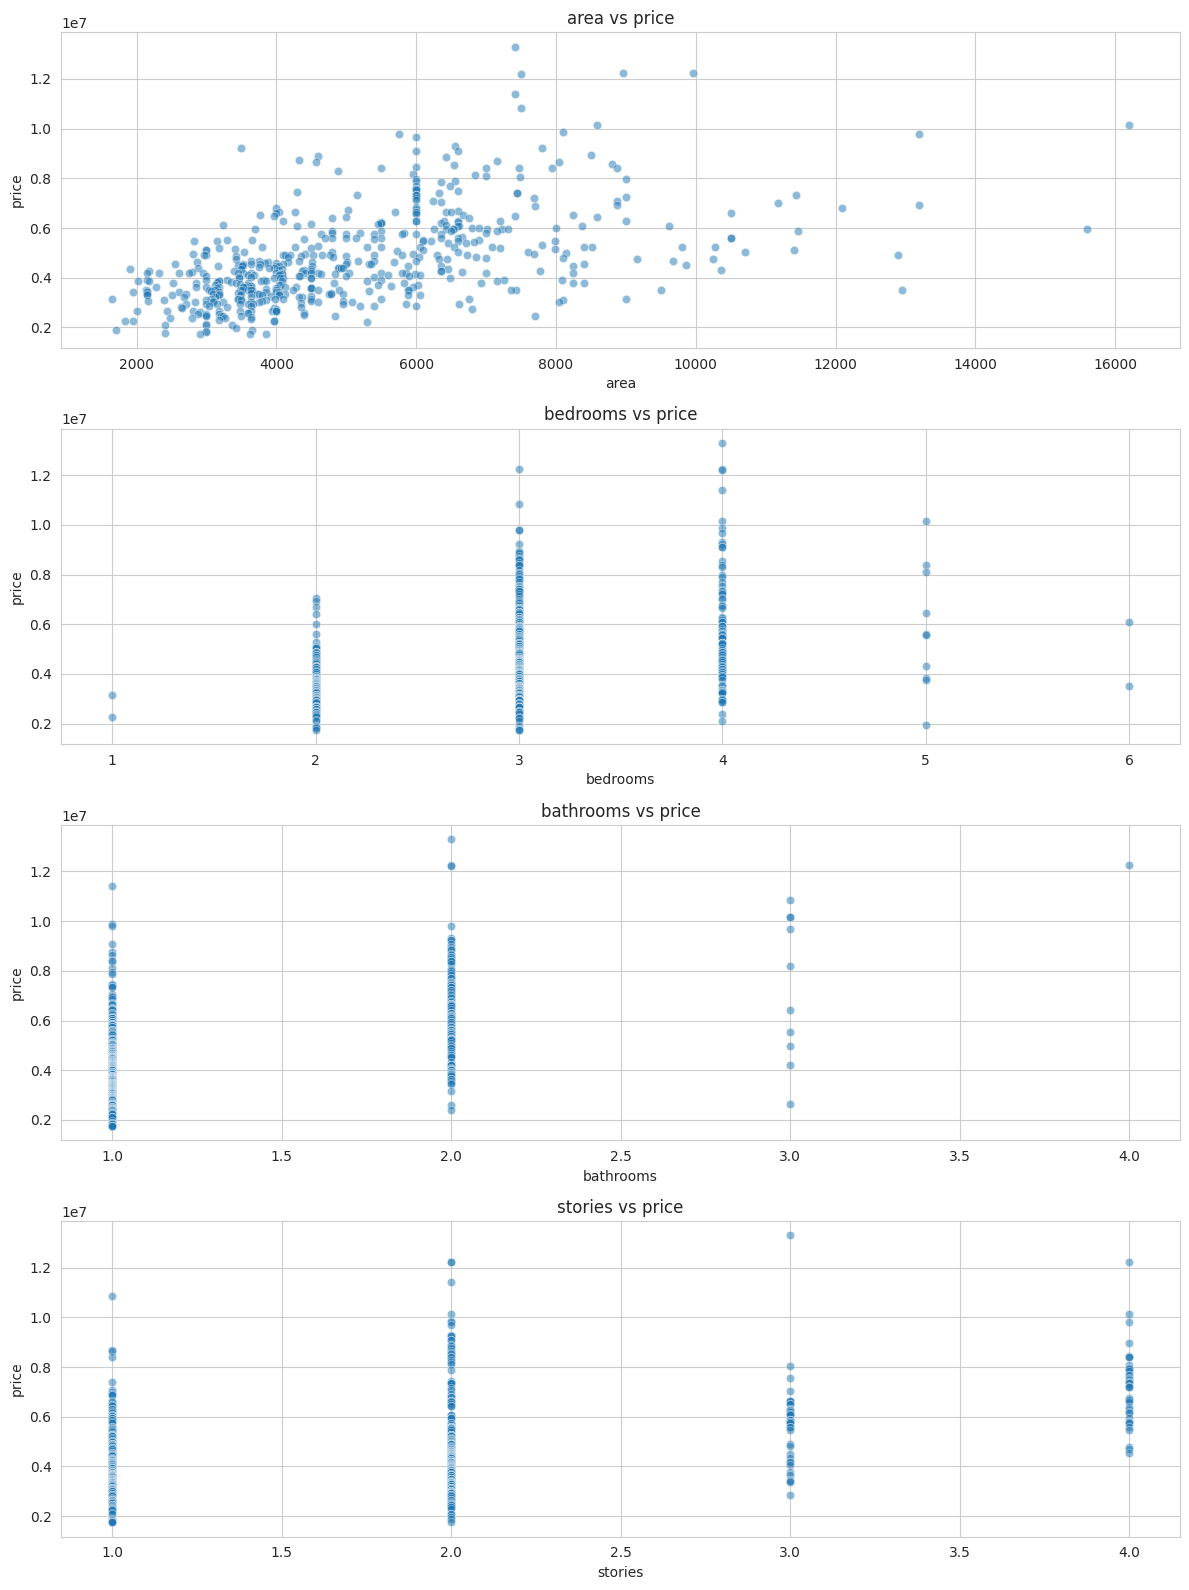

In [13]:
cols = num_cols[:4]
plt.figure(figsize=(12, 4*len(cols)))
for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    sns.scatterplot(x=df[col], y=df[target_col], alpha=0.5)
    plt.xlabel(col); plt.ylabel(target_col)
    plt.title(f"{col} vs {target_col}")
show_plot()

**Correlation Heatmap**

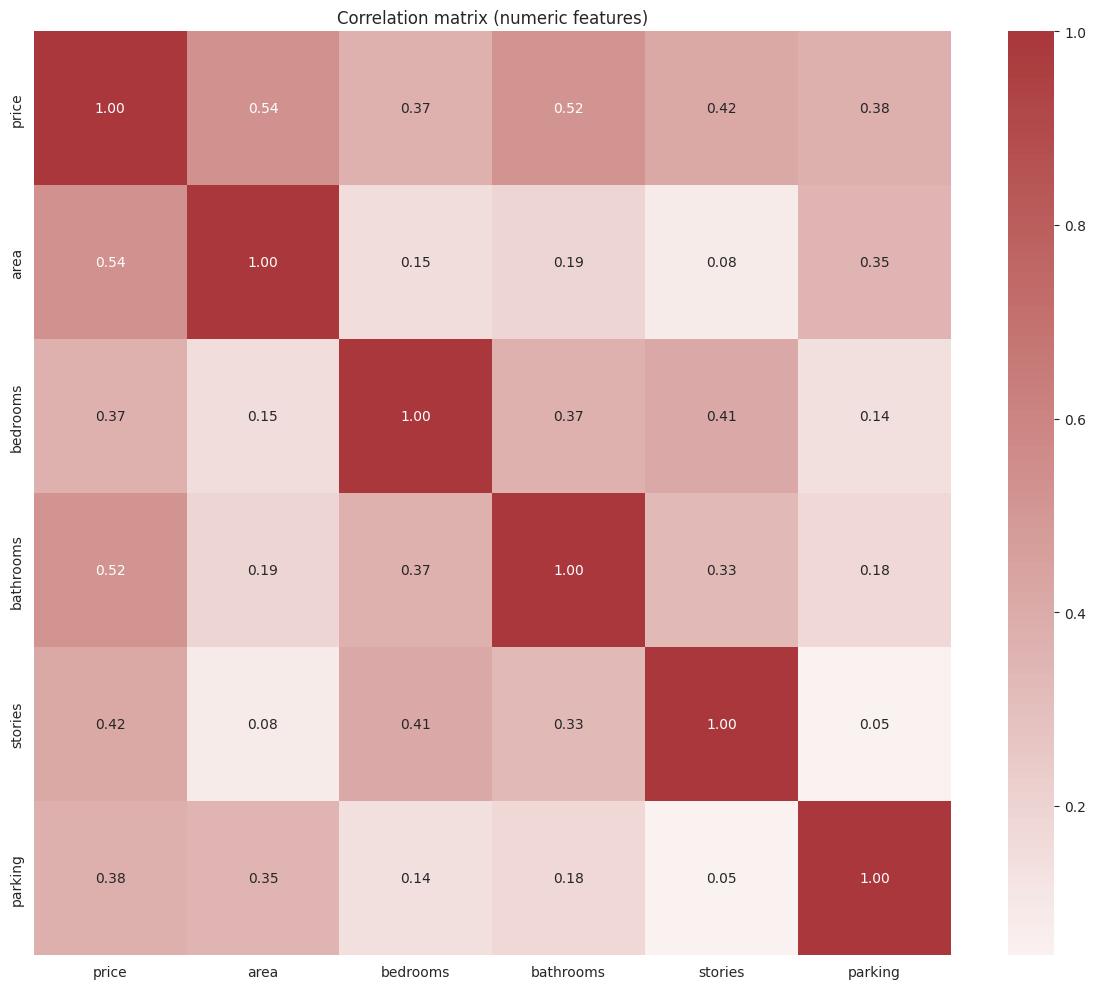

In [14]:
plt.figure(figsize=(12,10))
corr = df.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation matrix (numeric features)")
show_plot()

**Pairplot sample**

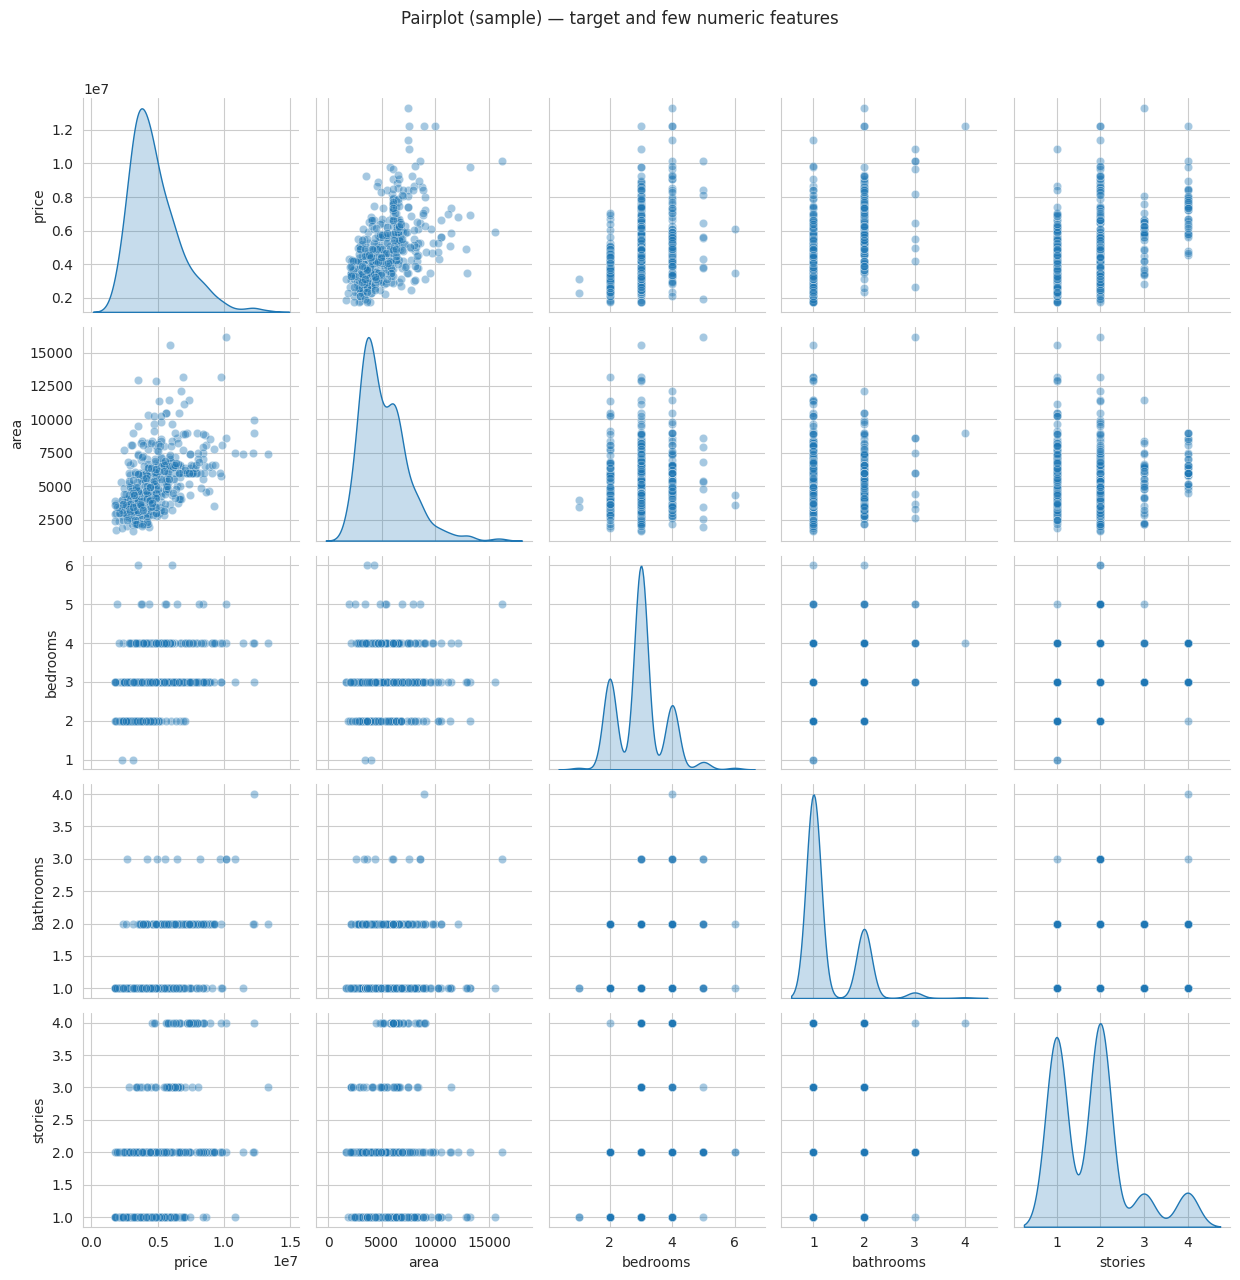

In [15]:
sample = df.sample(n=min(500, len(df)), random_state=42)
sns.pairplot(sample[[target_col] + num_cols[:4]], diag_kind='kde', plot_kws={'alpha':0.4})
plt.suptitle("Pairplot (sample) — target and few numeric features", y=1.02)
show_plot()

**Bar Charts for Top Categories**

Shows class imbalance and whether categories need merging.

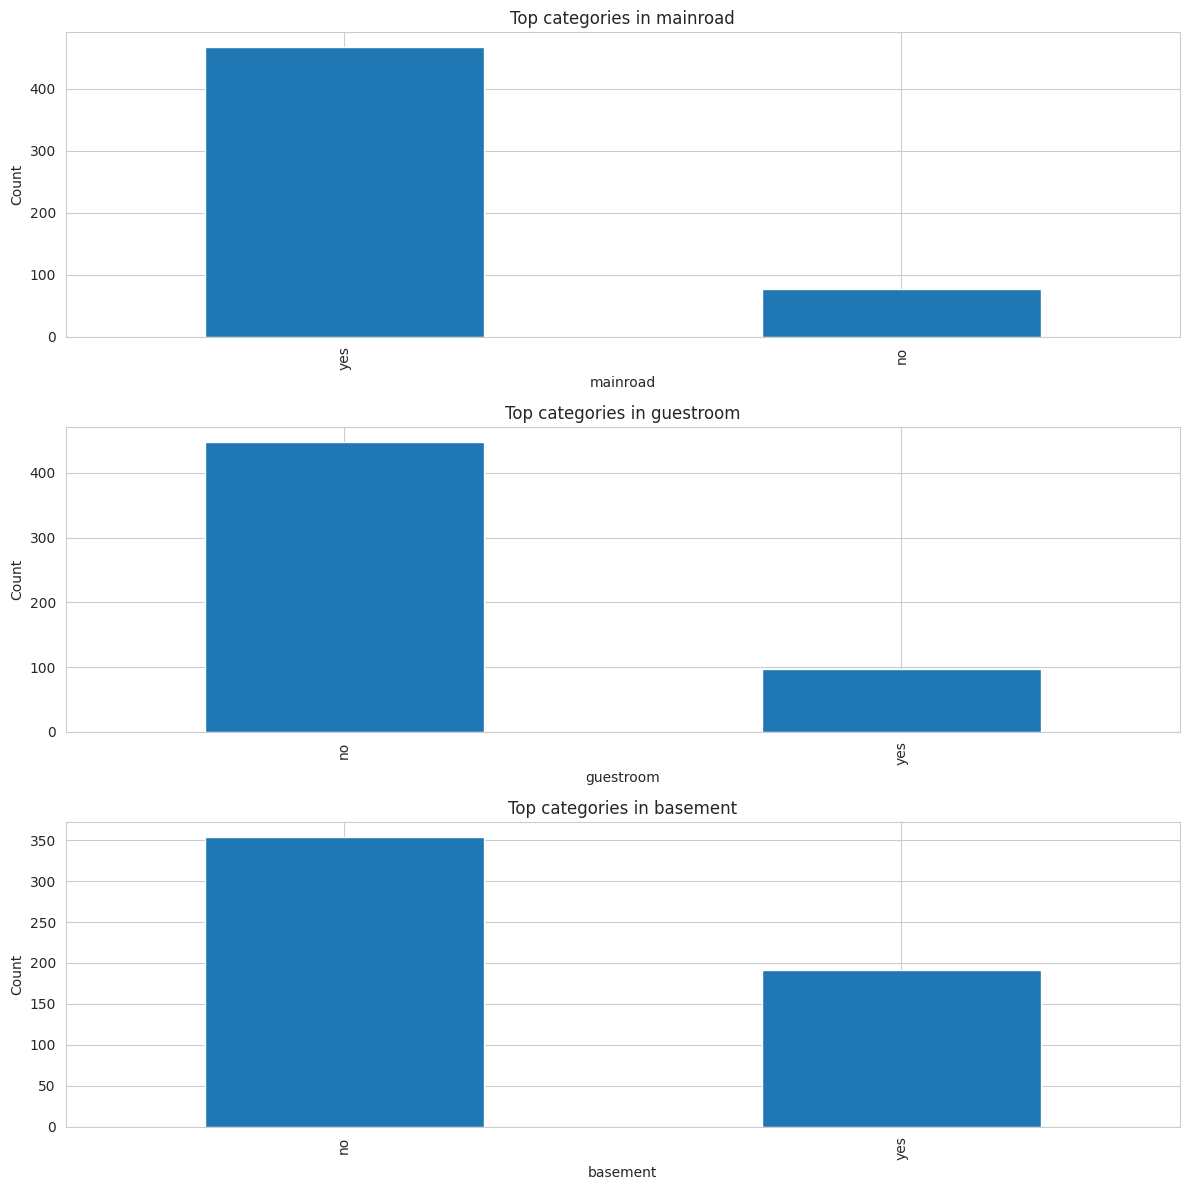

In [16]:
# Bar charts for categorical columns (after identifying categories)
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
cols = cat_cols[:3]  # change to view more
plt.figure(figsize=(12, 4*len(cols)))
for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    df[col].value_counts().nlargest(10).plot(kind='bar')
    plt.title(f"Top categories in {col}")
    plt.ylabel("Count")
show_plot()

**Pie chart for a categorical column**

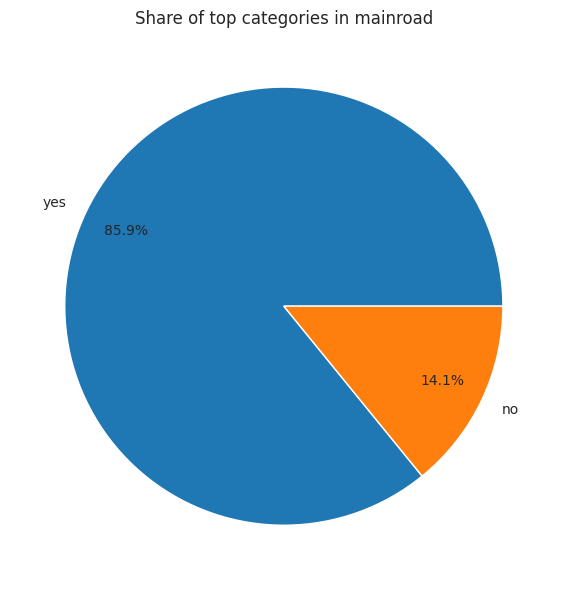

In [17]:
col = cat_cols[0] if cat_cols else None
if col:
    counts = df[col].value_counts().nlargest(8)
    plt.figure(figsize=(6,6))
    counts.plot(kind='pie', autopct='%1.1f%%', pctdistance=0.8)
    plt.ylabel('')
    plt.title(f"Share of top categories in {col}")
    show_plot()
else:
    print("No categorical columns found.")

Removing ID or irrelevant columns.

Dropping ID columns if they exist.

In [18]:
id_cols = [c for c in df.columns if 'id' in c.lower()]
print("Dropping ID columns:", id_cols)
df = df.drop(columns=id_cols)

Dropping ID columns: []


**Check target skewness and deciding transformation**

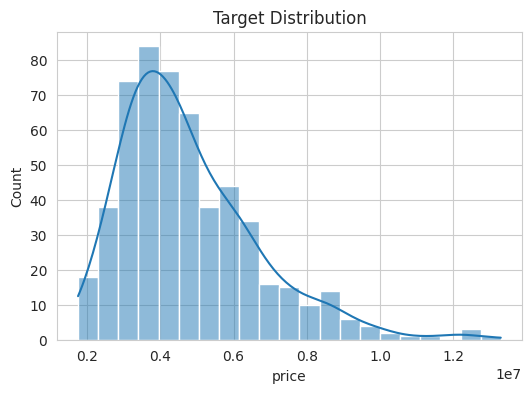

Skewness: 1.21
Applied log transformation to target variable.


In [19]:
target_col = "price"
plt.figure(figsize=(6,4))
sns.histplot(df[target_col], kde=True)
plt.title("Target Distribution")
plt.show()

skew = df[target_col].skew()
print(f"Skewness: {skew:.2f}")

if skew > 1:
    df[target_col] = np.log1p(df[target_col])
    print("Applied log transformation to target variable.")

**DATA PRE-PROCESSING**

**Identifying numerical and categorical columns**

In [20]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()

In [21]:
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

for c in ['id', 'Id', 'ID']:
    if c in numeric_cols:
        numeric_cols.remove(c)
        df.drop(columns=[c], inplace=True, errors='ignore')

print("Numeric cols:", len(numeric_cols), "Categorical cols:", len(categorical_cols))

Numeric cols: 5 Categorical cols: 7


**Transformers**

In [22]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # median robust to outliers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

**Outlier Detection Using IQR Method**

In [23]:
def detect_outliers_iqr(data, col, factor=1.5):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    mask = (data[col] < lower) | (data[col] > upper)
    return mask, lower, upper

mask, low, high = detect_outliers_iqr(df, target_col)
print(f"For {target_col}: lower={low:.2f}, upper={high:.2f}, outliers={mask.sum()} rows")
df[f'{target_col}_outlier_iqr'] = mask

For price: lower=14.28, upper=16.34, outliers=1 rows


**Outlier detection using z-score (Numeric columns)**

In [24]:
from scipy import stats
num_df = df.select_dtypes(include=['int64','float64']).fillna(0)
z_thresh = 3
z_scores = np.abs(stats.zscore(num_df))
z_outliers = (z_scores > z_thresh).any(axis=1)
print("Z-score method detected outliers:", z_outliers.sum())
df['outlier_zscore'] = z_outliers

Z-score method detected outliers: 19


**Splitting the Data**

Here we split the data into train and test sets.
If the target is skewed, we need to transform it.

In [25]:
if target_col not in df.columns:
    raise ValueError(f"Target column {target_col} not found in dataset")

y = df[target_col].copy()
X = df.drop(columns=[target_col])

print("Skewness of target:", y.skew())
use_log_target = True if y.skew() > 1 else False
if use_log_target:
    y = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Skewness of target: 0.14086281102108905
Train shape: (436, 14) Test shape: (109, 14)


**MODEL 1**

**Linear Regression**

In [26]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_train = lr_pipeline.predict(X_train)
y_pred_test = lr_pipeline.predict(X_test)

def evaluate(y_true, y_pred, desc=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{desc} RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

evaluate(y_train, y_pred_train, "LR Train")
evaluate(y_test, y_pred_test, "LR Test")

LR Train RMSE: 0.1919, MAE: 0.1485, R2: 0.7039
LR Test RMSE: 0.2516, MAE: 0.1999, R2: 0.6722


**MODEL 2 & 3**

**Random Forest and XG Boost**

In [27]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
evaluate(y_test, y_pred_rf, "RandomForest Test")

# XGBoost
if xgb_available:
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=200, random_state=42, n_jobs=1, verbosity=0))
    ])
    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb = xgb_pipeline.predict(X_test)
    evaluate(y_test, y_pred_xgb, "XGBoost Test")
else:
    print("XGBoost not installed; skip.")

RandomForest Test RMSE: 0.2666, MAE: 0.2092, R2: 0.6319
XGBoost Test RMSE: 0.2677, MAE: 0.2083, R2: 0.6289


**Hyperparameter Using Grid Search**

In [28]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

rf_for_search = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

grid = GridSearchCV(rf_for_search, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (neg RMSE):", grid.best_score_)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
evaluate(y_test, y_pred_best, "Tuned RF Test")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Best CV score (neg RMSE): -0.21169401093913848
Tuned RF Test RMSE: 0.2661, MAE: 0.2088, R2: 0.6332


**Feature Importance**

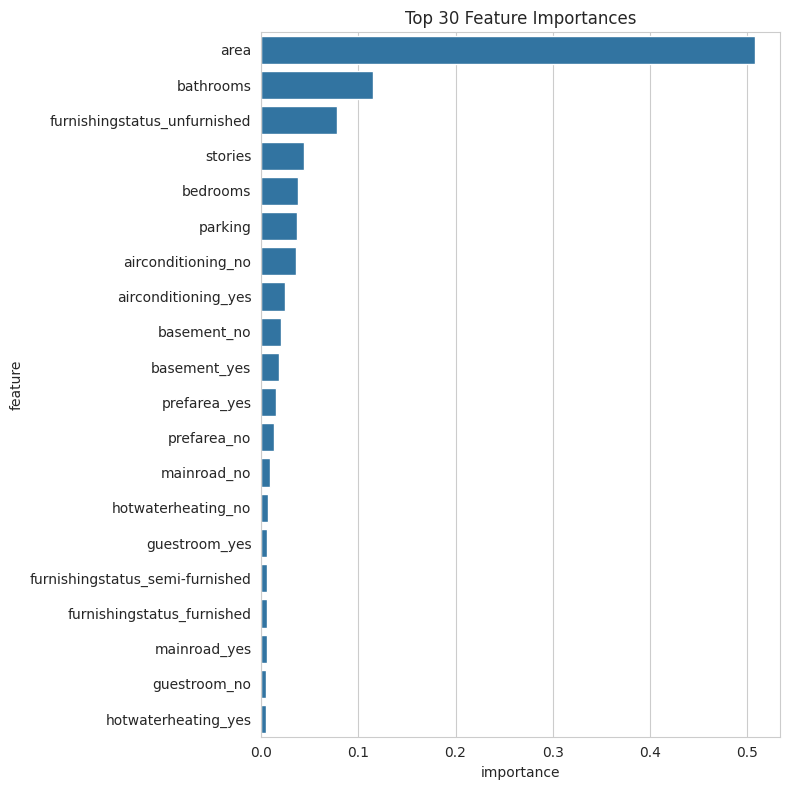

In [29]:
pre = best_rf.named_steps['preprocessor']
num_feats = numeric_cols

ohe = pre.named_transformers_['cat'].named_steps['onehot']
cat_feats = list(ohe.get_feature_names_out(categorical_cols))
feature_names = num_feats + cat_feats

importances = best_rf.named_steps['regressor'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).head(30)
plt.figure(figsize=(8,8))
sns.barplot(data=fi_df, x='importance', y='feature')
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()

**Final Evaluation**

Final (original units) RMSE: 0.2661404566222659
Final (original units) MAE: 0.20882565691815227
Final R2: 0.6331698111656929


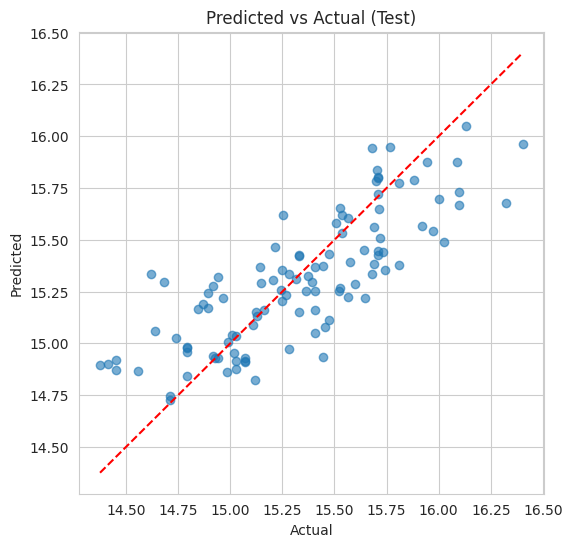

In [30]:
def invert_target(y_pred):
    if use_log_target:
        return np.expm1(y_pred)
    return y_pred

y_test_orig = invert_target(y_test)
y_pred_orig = invert_target(y_pred_best)

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
print("Final (original units) RMSE:", rmse)
print("Final (original units) MAE:", mae)
print("Final R2:", r2)

plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test)")
plt.show()

In [31]:
y_pred = best_rf.predict(X_test)
y_test

,price
316,15.216694
77,15.710128
360,15.126543
90,15.678039
493,14.845130
...,...
15,16.023785
357,15.143381
39,15.883638
54,15.810211


**Residuals Plot**

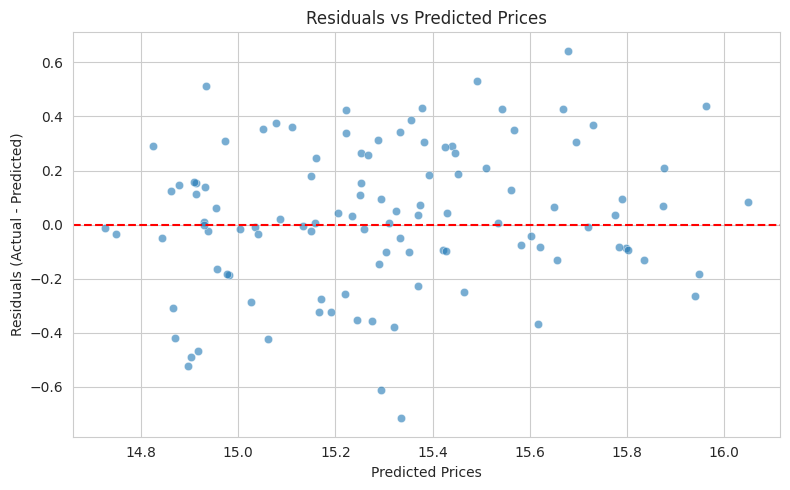

In [32]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Prices")
show_plot()

**Error Distribution**

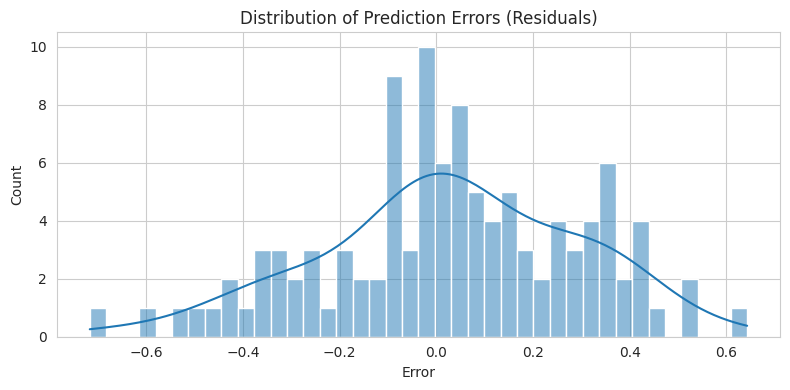

In [33]:
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error")
show_plot()

Comparing all the 3 models

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

models = {
    "Linear Regression": lr_pipeline,
    "Random Forest (Tuned)": best_rf,
    "Random Forest (Untuned)": rf_pipeline,
    "XGBoost": xgb_pipeline if xgb_available else None # Include XGBoost only if available
}

models = {name: model for name, model in models.items() if model is not None}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    if use_log_target:
        y_pred = np.expm1(y_pred)
        y_test_eval = np.expm1(y_test)
    else:
        y_test_eval = y_test

    mae = mean_absolute_error(y_test_eval, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred))
    r2 = r2_score(y_test_eval, y_pred)

    results.append({
        "Model": name,
        "R² Score": round(r2, 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    })
results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
display(results_df)

,Model,R² Score,MAE,RMSE
0,Linear Regression,0.6722,0.1999,0.2516
1,Random Forest (Tuned),0.6332,0.2088,0.2661
2,Random Forest (Untuned),0.6319,0.2092,0.2666
3,XGBoost,0.6289,0.2083,0.2677


**CONCLUSION**

Data preprocessing, feature engineering, model training, and evaluation were all successfully incorporated into a strong machine learning pipeline for housing price prediction. The model's scalability, repeatability, and dependability are all enhanced by the organized and automated workflow. The findings show that the model successfully captures important variables affecting home values, offering precise forecasts and a solid basis for practical implementation and upcoming advancements.